In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
from collections import defaultdict
import datetime
import importlib

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import sys, os
from utils.utils import plot_mean_std, delete_dfs, smoothen, concat, df_round_time
import scipy.optimize

import re 
matplotlib.rcParams["figure.dpi"] = 150
matplotlib.rcParams["axes.grid"] = True

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
mathematica_exports = "/home/ashmat/Desktop/ashmat/mathematica_exports/"
files = sorted([line for line in os.listdir(mathematica_exports) if "ER300" in line])
files

['ER300.15-523-0.0195-205000-(1592).h5',
 'ER300.15-523-0.0195-205000-(1592).h5.csv',
 'ER300.15-523-0.0195-205000-(1592).h5.imgs',
 'ER300.15-523-0.0195-205000-(1592).h5.plus.csv',
 'ER300.25-523-0.0228-205000-(1594).h5',
 'ER300.25-523-0.0228-205000-(1594).h5.csv',
 'ER300.25-523-0.0228-205000-(1594).h5.imgs',
 'ER300.25-523-0.0228-205000-(1594).h5.plus.csv',
 'ER300.35-523-0.0258-205000-(1455).h5',
 'ER300.35-523-0.0258-205000-(1455).h5.csv',
 'ER300.35-523-0.0258-205000-(1455).h5.imgs',
 'ER300.35-523-0.0258-205000-(1455).h5.plus.csv',
 'ER300.45-523-0.0283-205000-(1541).h5',
 'ER300.45-523-0.0283-205000-(1541).h5.csv',
 'ER300.45-523-0.0283-205000-(1541).h5.imgs',
 'ER300.45-523-0.0283-205000-(1541).h5.plus.csv',
 'ER300.55-523-0.0312-205000-(1515).h5',
 'ER300.55-523-0.0312-205000-(1515).h5.csv',
 'ER300.55-523-0.0312-205000-(1515).h5.imgs',
 'ER300.55-523-0.0312-205000-(1515).h5.plus.csv',
 'ER300.6-523-0.0155-205000-(1553).h5',
 'ER300.6-523-0.0155-205000-(1553).h5.csv',
 'ER30

In [3]:
[line for line in os.listdir(mathematica_exports) if "ERlong" in line]

['ERlong-523-0.0374-205000-(1560).h5.imgs',
 'ERlong-523-0.0374-205000-(575).h5.plus.csv',
 'ERlong-523-0.0380-705000-(1200).h5',
 'ERlong-523-0.0374-205000-(1560).h5.csv',
 'ERlong-523-0.0380-705000-(456).h5',
 'ERlong-523-0.0380-705000-(598).h5',
 'ERlong-523-0.0374-205000-(575).h5.imgs',
 'ERlong-523-0.0374-205000-(575).h5',
 'ERlong-199-0.0285-705000-(813).h5',
 'ERlong-523-0.0374-205000-(596).h5',
 'ERlong-523-0.0380-705000-(1200).h5.imgs',
 'ERlong-523-0.0380-705000-(456).h5.csv',
 'ERlong-523-0.0374-205000-(575).h5.csv',
 'ERlong-523-0.0374-205000-(1560).h5',
 'ERlong-523-0.0380-705000-(1200).h5.csv']

In [20]:
files2 = []
for file in files:
    fa = re.findall(r"^.+\((\d+)\)\.h5$", file)
    if len(fa)>0 and int(fa[0]) > 1400:
        files2.append(file)
print("\n".join(files2))

ER300.15-523-0.0195-205000-(1592).h5
ER300.25-523-0.0228-205000-(1594).h5
ER300.35-523-0.0258-205000-(1455).h5
ER300.45-523-0.0283-205000-(1541).h5
ER300.55-523-0.0312-205000-(1515).h5
ER300.6-523-0.0155-205000-(1553).h5


In [22]:
names = files2.copy()

In [23]:
names

['ER300.15-523-0.0195-205000-(1592).h5',
 'ER300.25-523-0.0228-205000-(1594).h5',
 'ER300.35-523-0.0258-205000-(1455).h5',
 'ER300.45-523-0.0283-205000-(1541).h5',
 'ER300.55-523-0.0312-205000-(1515).h5',
 'ER300.6-523-0.0155-205000-(1553).h5']

In [195]:
names = [
 'ER300.15-523-0.0195-205000-(884).h5',
 'ER300.25-523-0.0228-205000-(614).h5',
 'ER300.35-523-0.0258-205000-(545).h5',
 'ER300.45-523-0.0283-205000-(611).h5',
 'ER300.55-523-0.0312-205000-(827).h5',
 'ER300.6-523-0.0155-205000-(789).h5',

    "ERlong-523-0.0380-705000-(456).h5",
"ERlong-523-0.0374-205000-(575).h5"
]


In [8]:
names = ["ERlong-523-0.0374-205000-(1560).h5", "ERlong-523-0.0380-705000-(1200).h5"]

In [24]:
items = [
    {"sim":pd.read_hdf(os.path.join(mathematica_exports, name)),
        "gamma":pd.read_csv(os.path.join(mathematica_exports, name+".csv"), 
            header=None).set_axis(["time","noneq", "_", "quasieq"], axis=1).set_index("time")}
    for name in tqdm(names)]
     

  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
def get_subdf(df, t, wide):
    return df.loc[t-wide/2:t+wide/2]

In [26]:
def get_gamma(df, t, wide, a, eps):
    subdf = get_subdf(df, t, wide)
    O = subdf["T"].mean()
    slope, _ = np.polyfit(subdf.index.values, subdf["O"].values, 1)
    gamma = -4 * a**2 * eps**2 * O * (3* a**2 - O**2) / (3* a**2 + O**2) / slope
    return gamma

In [13]:
a = 0.2
eps = 0.0283**2/4
item = items[0]

In [27]:
for name, item in zip(tqdm(names), items):
    ecc = float(re.findall(r"^.+\-\d+\-([\d\.]+)\-\d+\-\(\d+\).h5$",name)[0])
    eps = ecc**2/4
    a = 0.2
    
    
    df_sim, df_gam = item["sim"], item["gamma"]
    T = []
    O = []
    L = []
    fromL = []
    wide = 500
    for i in range(len(df_gam.index)):
        t = df_gam.index[i]
        t_left = df_gam.index[i-1] if i > 0 else 0
        t_right = df_gam.index[i+1] if i < len(df_gam.index)-1 else df_sim.index[-1]
        
        fact = 4
        t_left = t - (t-t_left) * fact
        t_right = t + (t_right-t) * fact
        
        
        
        subdf =get_subdf(df_sim, t, wide)
        T.append(subdf["T"].mean())
        O.append(subdf["O"].mean())
        L.append(subdf["L"].mean())
        
        subdf = df_sim.loc[t_left: t_right]
        slope,_ = np.polyfit(subdf["L"].index,np.log(subdf["L"]),1)
        fromL.append(-4 * a**2 * eps**2 / slope)
        
    df_gam["T"] = T
    df_gam["O"] = O
    df_gam["L"] = L
    df_gam["fromL"] = fromL
    
        
        

  0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
items[-1]["gamma"].loc[10000:]["noneq"].mean()

0.002815313846530298

(0.0, 0.005)

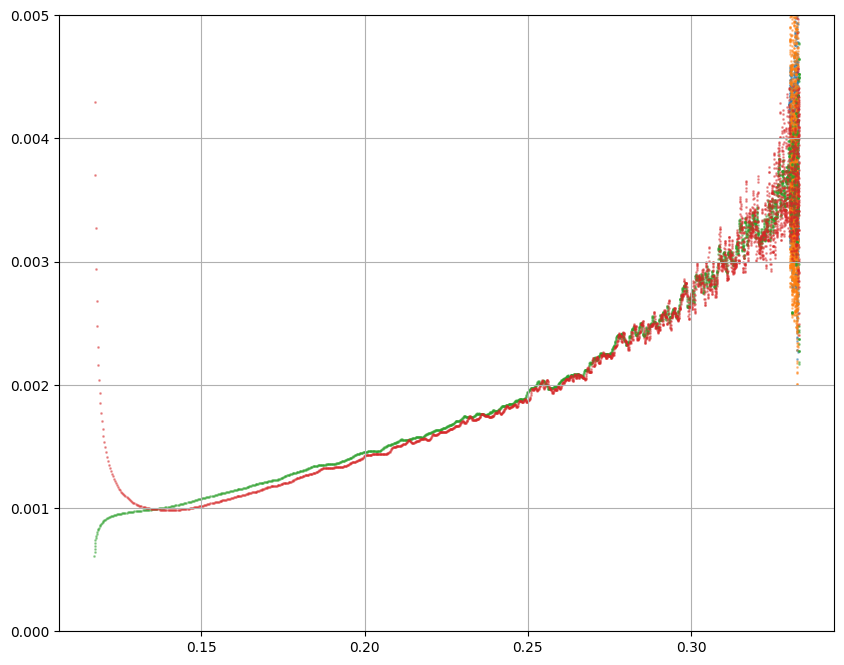

In [17]:
plt.figure(figsize=(10,8), dpi=100)
for item in items[:]:
    df_gam = item["gamma"]
    plt.scatter(df_gam["T"], df_gam["noneq"], s=1, alpha=0.4)
    plt.scatter(df_gam["T"], df_gam["fromL"], s=1, alpha=0.4)
    
    
# item = items[-2]
# df_gam = item["gamma"].loc[:300000]
# plt.scatter(df_gam["T"], df_gam["noneq"], s=1, alpha=0.4)
    
# plt.hlines(y=items[-1]["gamma"].loc[10000:]["noneq"].mean(),xmin=0.325,xmax=0.335)
T = np.linspace(0.12,0.3,100)
# plt.plot(T, T**2 * (0.0007/0.12**2))
plt.ylim(0,0.005)

In [230]:
df_gam = items[-2]["gamma"].loc[:3000000]

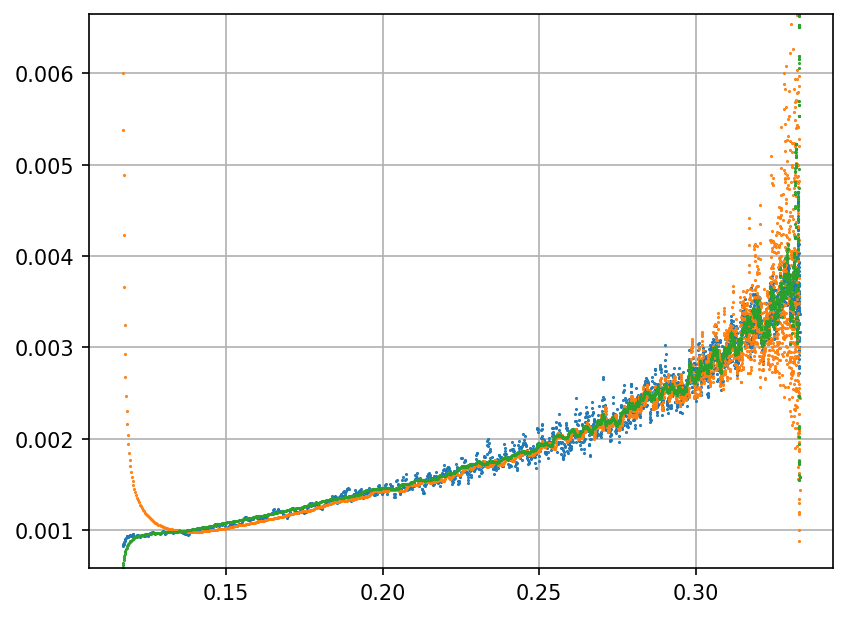

In [232]:
plt.ylim(df_gam["noneq"].min(), df_gam["noneq"].max())
plt.plot(df_gam["T"],df_gam["quasieq"], ".", ms=1)
plt.plot(df_gam["T"],df_gam["fromL"], ".", ms=1)
plt.plot(df_gam["T"],df_gam["noneq"], ".", ms=1)


In [172]:
df_gam["noneq"].iloc[0]

0.0008431737198643

<Axes: xlabel='time'>

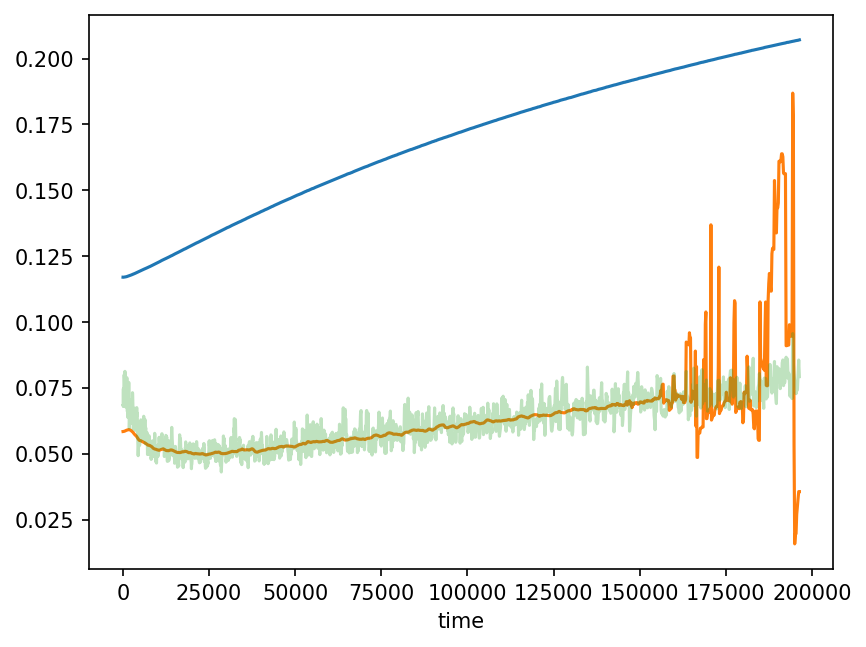

In [175]:
df_gam["T"].plot()
(df_gam["noneq"]/df_gam["noneq"].iloc[0] * df_gam["T"].iloc[0]/2).plot()
(df_gam["quasieq"]/df_gam["noneq"].iloc[0] * df_gam["T"].iloc[0]/2).plot(alpha=0.3)

<Axes: >

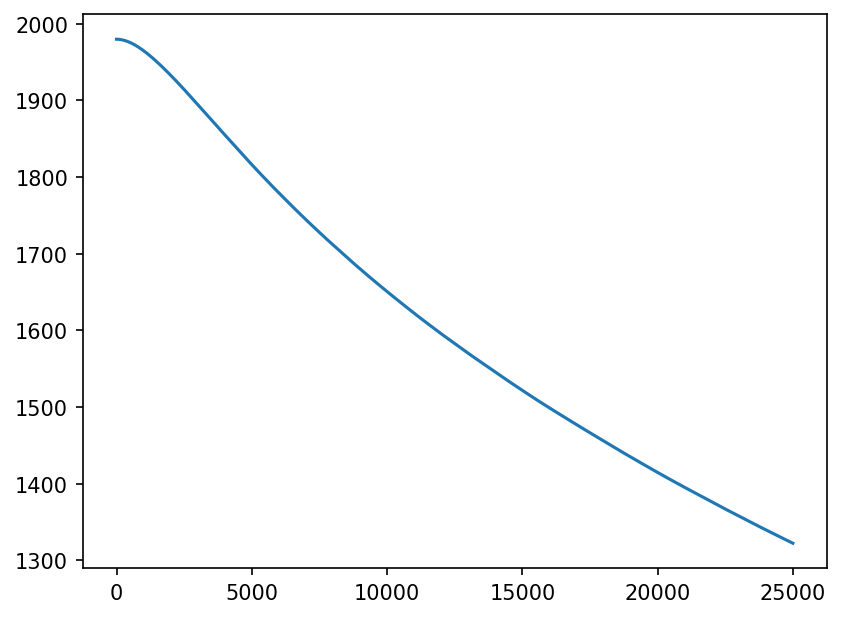

In [125]:
item["sim"]["L"].loc[:25000].plot()

In [28]:
for name, item in zip(names, items):
    df_gam = item["gamma"]
    df_gam.to_csv(os.path.join(mathematica_exports, name+".plus.csv"), header=False)

In [29]:
df_gam.to_csv("./test.csv", header=False)

In [19]:
df_gam.columns

Index(['noneq', '_', 'quasieq', 'T', 'O', 'L', 'fromL'], dtype='object')

In [259]:
items[-2]["gamma"]["T"].iloc[-100]

0.3323352524010188

In [34]:
files = os.listdir("/data/biophys/ashmat/outputs/")

In [40]:
files1 = [file for file in tqdm(files) if "14164438_1142" in file]

  0%|          | 0/394177 [00:00<?, ?it/s]

In [41]:
files1

[]